# Trabalho #7 - Transferência de Aprendizado

Nesse trabalho você vai utilizar uma RNA pré-treinada para realizar uma tarefa de classificação de múltiplas classes. A tarefa é a mesma do Trabalho #6, que consiste na identificação de sinais de mão a partir de imagens. A rede pré-treinada que iremos utilizar é a VGG16 que está disponível no Keras.

## Coloque os nomes e RAs dos alunos que fizeram esse trabalho

Nome e número dos alunos da equipe:

Aluno 1: Igor Amaral Correa 20.83992-8

Aluno 2: 

Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados ao longo nesse trabalho:
- numpy pacote de cálculo científico com Python
- matplotlib biblioteca para gerar gráficos em Python
- h5py biblioteca que permite ler e escrever arquivos no formato h5
- utils.py função para ler banco de dados 

In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils import *
import tensorflow as tf

%matplotlib inline

## 1 - Visão geral do problema ##

**Definição do problema**: 

O objetivo desse problema é desenvolver uma RNA que recebe como entrada uma imagem de sinais de mão, avalia a probabilidade dos dedos da mão mostrarem um número de 0 a 5 e determina qual o número mais provável entre os seis possíveis.

O banco de dados usado nesse trabalho é SIGNS, que consiste de imagens de sinais de mão desenvolvido por Andre Ng (deeplearning.ai). Esse banco de dados pode ser obtido no link: https://github.com/cs230-stanford/cs230-code-examples/tree/master/tensorflow/vision

O banco de dados possui 1080 exemplos de treinamento e 120 exemplos de teste. Cada exemplo consiste de uma imagem colorida associada a um rótulo de 6 classes. A Figura 1 abaixo mostra alguns exemplos dessas imagens.


<img src="SIGNS.png" style="width:800px;height:300px;">

## 2 - Dados de treinamento

Os dados que iremos utilizar nesse trabalho estão nos arquivos train_signs.h5 e test_signs.h5.

Características dos dados:

- As imagens são coloridas e estão no padrão RGB;
- Cada imagem tem dimensão de 64x64x3;
- O valor da intensidade luminosa de cada plano de cor é um número inteiro entre 0 e 255;
- As saídas representam o rótulo do sinal de mão mostrado na imagem, sendo um número inteiro de 0 a 5. 



### 2.1 - Leitura dos dados

Para iniciar o trabalho é necessário ler o arquivo de dados. Assim, execute o código da célula abaixo para ler o arquivo de dados.

In [2]:
# Leitura do arquivo de dados
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
print("X_train shape:", X_train_orig.shape, "y_train shape:", Y_train_orig.shape)
print("X_test shape:", X_test_orig.shape, "y_test shape:", Y_test_orig.shape)

X_train shape: (1080, 64, 64, 3) y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3) y_test shape: (1, 120)


Pela dimensão dos tensores com os dados de treinamento e teste temos:

- 1080 imagens de treinamento com dimensão de 64x64x3 pixels;
- 120 imagens de teste com dimensão de 64x64x3 pixels.


Execute a célula a seguir para visualizar um exemplo de uma imagem do banco de dados juntamente com a sua classe. Altere o valor da variável 'index' e execute a célula novamente para visualizar mais exemplos diferentes.

y = 0


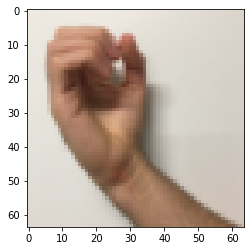

In [3]:
# Examplo de uma imagemo
index = 18
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### 2.2 - Processamento dos dados

Para os dados poderem ser usados para o desenvolvimento da RNA devemos primeiramente processá-los.

Para isso devemos realizar as seguintes etapas:

- Dividir os dados de treinamento nos conjuntos de treinamento e validação;
- Os valores dos pixels em uma imagem é um número inteiro que deve ser transformado em número real para ser usado em cálculos;
- Redimensionar as imagens para transfroma-las em um vetor linha;
- Normalizar as imagens de forma que os valores dos pixels fique entre 0 e 1.

**Divisão do conjunto de dados de treinamento**

Execute a célula abaixo para para dividir o conjunto de dados de treinamento nos conjuntos de treinamento e validação e redimensionar as saídas para que o primeiro eixo seja o dos exemplos e o segundo eixo o das classes.

In [4]:
# Dados de entrada
X_train_int = X_train_orig[:960,:]
X_val_int = X_train_orig[960:,:]

# Dados de saída
Y_train = Y_train_orig[:,:960].T
Y_val = Y_train_orig[:,960:].T
Y_test = Y_test_orig.T

print("Dimensão do tensor de dados de entrada de treinamento =", X_train_int.shape)
print("Dimensão do tensor de dados de entrada de validação =", X_val_int.shape)
print("Dimensão do tensor de dados de saída de treinamento =", Y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", Y_val.shape)
print("Dimensão do tensor de dados de saída de test =", Y_test.shape)

Dimensão do tensor de dados de entrada de treinamento = (960, 64, 64, 3)
Dimensão do tensor de dados de entrada de validação = (120, 64, 64, 3)
Dimensão do tensor de dados de saída de treinamento = (960, 1)
Dimensão do tensor de dados de saída de validação = (120, 1)
Dimensão do tensor de dados de saída de test = (120, 1)


**Normalização dos dados de entrada**

Execute a célula abaixo para normalizar e transformar as imagens em números reais dividindo por 255.

In [5]:
# Guarda dimensão das imagens
image_dim = X_train_int.shape[1:4]
print("Dimensão das imagens de entrada=", image_dim)

# Transformação dos dados em números reais
X_train = X_train_int.astype('float32') / 255
X_val = X_val_int.astype('float32')/255
X_test = X_test_orig.astype('float32') / 255

Dimensão das imagens de entrada= (64, 64, 3)


**Codificação das classes**

As classes dos sinais são identificadas por um número inteiro que varia de 0 a 5. Porém, a saída esperada de uma RNA para um problema de classificação de múltiplas classes é um vetor de dimensão igual ao número de classes, que no caso são 6 classes. Cada elemento desse vetor representa a probabilidade da imagem ser um sinal. Assim, devemos transformar as saídas reais do conjunto de dados em um vetor linha de 6 elementos, com todos os elementos iguais a zero a menos do correspondente ao da classe do sinal, que deve ser igual a um. A função que realiza essa transformação é conhecida na literatura de “one-hot-encoding”, que no Keras é chamada de "to_categorical". Execute a célula abaixo para transformar os dados de saída usando a função "to_categorical" do keras.


In [6]:
# Importa classe de utilidades do Keras
from tensorflow.keras.utils import to_categorical

# Transformação das classes de números reais para vetores
Y_train_hot = to_categorical(Y_train) 
Y_val_hot = to_categorical(Y_val) 
Y_test_hot = to_categorical(Y_test)

print('Dimensão dos dados de saída do conjunto de treinamento: ', Y_train_hot.shape)
print('Dimensão dos dados de saída do conjunto de validação: ', Y_val_hot.shape)
print('Dimensão dos dados de saída do conjunto de teste: ', Y_test_hot.shape)

Dimensão dos dados de saída do conjunto de treinamento:  (960, 6)
Dimensão dos dados de saída do conjunto de validação:  (120, 6)
Dimensão dos dados de saída do conjunto de teste:  (120, 6)


**Visualização da entrada e saída correspondente**

Execute a célula abaixo para verificar se o programa realizou de fato o que era esperado. No código abaixo index é o número sequencial da imagem. Tente trocar a imagem, mudando o index, usando valores entre 0 e 959, para visualizar outros exemplos.

Classe numérica:  [0] , Vetor de saída correspondentes:  [1. 0. 0. 0. 0. 0.]


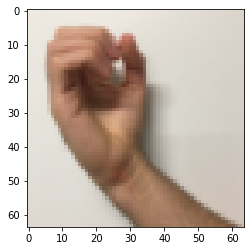

In [7]:
# Exemplo de saída
index = 18
print("Classe numérica: ", Y_train[index], ", Vetor de saída correspondentes: ", Y_train_hot[index])
plt.imshow(X_train_orig[index], cmap='gray', vmin=0, vmax=255)

## 3 - RNA convolucional base

Nesse trabalho você irá usar uma RNA convolucional já treinada como base para criar outra RNA para realizar uma tarefa diferente da que a RNA base foi treinada. A RNA que será usada como base é a VGG16 vista em aula (Simonyan & Zisserman, Very deep convolutional networks for large-scale image recognition, 2015). 

A VGG16 foi desenvolvida para classificação de múltiplas classes com 1.000 classes. Ela é uitlizada para reconhecimento de objetos em imagens. A arquitetura da VGG é muito simples, sendo composta pela repetição de camadas convolucionais formando blocos. Cada bloco é composto por duas ou três camadas convolucionais, com filtros 3x3, stride = 1 e “same convolution”, seguida por uma camada de max-pooling, com janela 2x2 e stride = 2. A VGG16 mantém o mesmo padrão em todos os blocos dobrando o número de filtros a cada bloco. Apesar da VGG16 possuir muitos parâmetros, cerca de 138 milhões, ela é muito simples.

### Exercício #1: Carregar a VGG16

O TensorFlow-Keras possui na sua base de dados a RNA VGG16 treinada com o banco de imagens imagenet. Complete a célula abaixo para carregar a VGG16. Não se esqueça de excluir a parte densa e de definir a dimensão das imagens ao salvar a VGG16.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

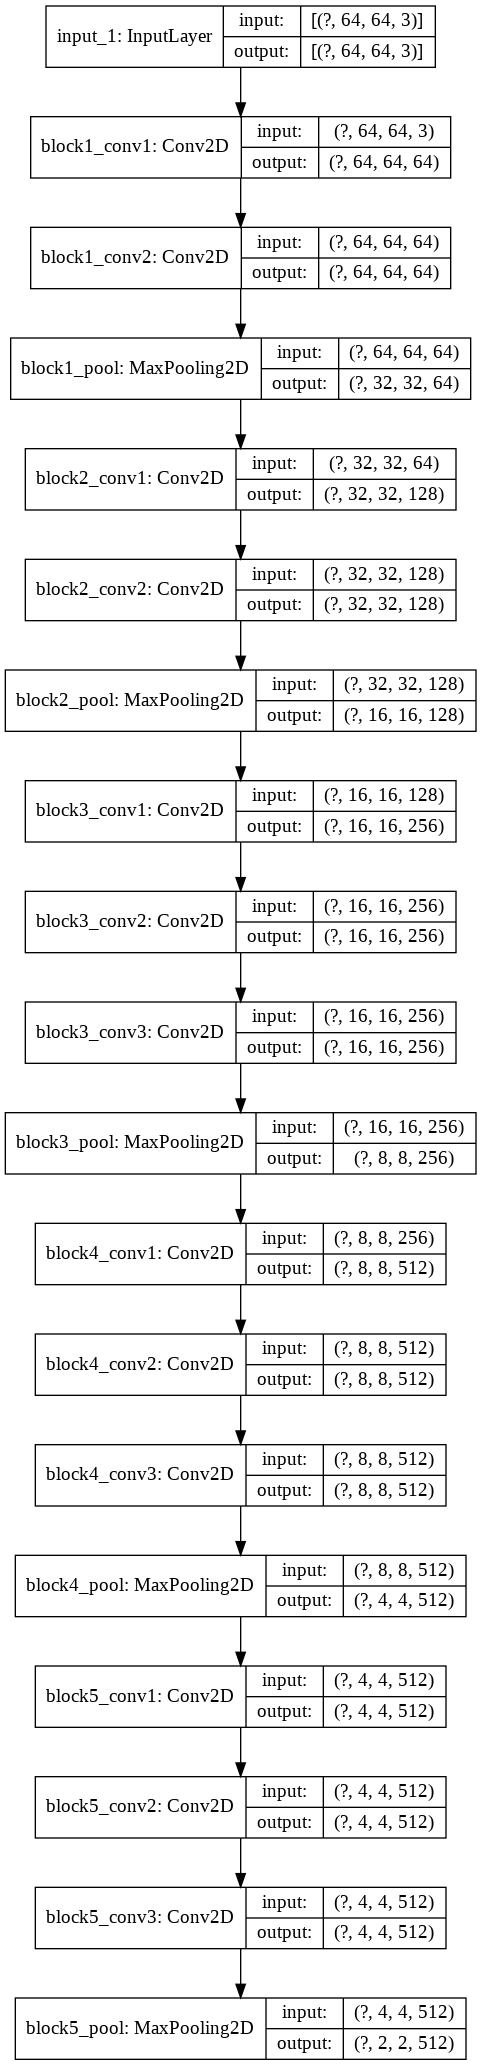

In [8]:
# PARA VOCÊ FAZER: carregar e salvar a VGG16 na rna_base

# Importa função para fazer gráfico de RNAs
from tensorflow.keras.utils import plot_model

# Carrega e salva a VGG16 excluindo suas camadas densas 
### COMECE AQUI ### (≈ 2 linhas)
from tensorflow.keras.applications import VGG16
rna_base = VGG16(weights='imagenet', include_top=False, input_shape=image_dim)
### TERMINE AQUI ####

# Mostra a arquitetura da VGG16
rna_base.summary()

# Cria um arquivo com o esquema da VGG16
plot_model(rna_base, to_file='VGG16.png', show_shapes=True)  


**Saída esperada:**

    Model: "vgg16"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 64, 64, 3)         0         
    _________________________________________________________________
    block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
    _________________________________________________________________
    block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
    _________________________________________________________________
    block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
    _________________________________________________________________
    block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
    _________________________________________________________________
    block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
    _________________________________________________________________
    block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
    _________________________________________________________________
    block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
    _________________________________________________________________
    block3_conv2 (Conv2D)        (None, 16, 16, 256)       590080    
    _________________________________________________________________
    block3_conv3 (Conv2D)        (None, 16, 16, 256)       590080    
    _________________________________________________________________
    block3_pool (MaxPooling2D)   (None, 8, 8, 256)         0         
    _________________________________________________________________
    block4_conv1 (Conv2D)        (None, 8, 8, 512)         1180160   
    _________________________________________________________________
    block4_conv2 (Conv2D)        (None, 8, 8, 512)         2359808   
    _________________________________________________________________
    block4_conv3 (Conv2D)        (None, 8, 8, 512)         2359808   
    _________________________________________________________________
    block4_pool (MaxPooling2D)   (None, 4, 4, 512)         0         
    _________________________________________________________________
    block5_conv1 (Conv2D)        (None, 4, 4, 512)         2359808   
    _________________________________________________________________
    block5_conv2 (Conv2D)        (None, 4, 4, 512)         2359808   
    _________________________________________________________________
    block5_conv3 (Conv2D)        (None, 4, 4, 512)         2359808   
    _________________________________________________________________
    block5_pool (MaxPooling2D)   (None, 2, 2, 512)         0         
    =================================================================
    Total params: 14,714,688
    Trainable params: 14,714,688
    Non-trainable params: 0


**Observações:**

- A parte convolucional da VGG16 possui 5 blocos, sendo que cada bloco possui 2 ou 3 camadas convolucionais seguidas por uma camada de max-pooling.
- A VGG16 não é uma rede muito profunda, possuindo 13 camadas convolucionais.
- Apesar do grande número de parâmetros (138 milhões para a VGG16 completa com as suas camadas densas), a VGG16 é uma rede muito simples e rápida de ser excecutada e treinada, quando comparada com outras RNAs de mesmo desempenho.
- O esquema da VGG16 que você carregou foi gerado no arquivo VGG16.png que está no diretório que você está utilizando. Para ver esse esquema basta abrir esse arquivo.

## 4 - Uso da RNA base para extrair caracteríticas

Nessa parte do trabalho você vai usar a RNA base somente para extrair as caracteríticas das imagens de treinamento, validação e teste. Essas caracterísitcas serão usadas como entrada de uma nova RNA densa que será treinada para realizar a tarefa de classificação dos sinais.


### Exercício #2: Extração das características das imagens 

Na célula abaixo crie um código para executar a rna_base na forma de previsão para extrair as características das imagens de treinamento, validação e teste.

In [9]:
# PARA VOCÊ FAZER: gerar as características das imagens de treinamento, validação e teste pela rna_base.

#### COMECE AQUI ### (≈ 3 linhas) 
train_features = rna_base.predict( X_train )
val_features = rna_base.predict( X_val )
test_features = rna_base.predict( X_test )
### TERMINE AQUI ###

print("Dimensão do tensor de características das imagens de treinamento = ", train_features.shape)
print("Dimensão do tensor de características das imagens de validação = ", val_features.shape)
print("Dimensão do tensor de características das imagens de teste = ", test_features.shape)

Dimensão do tensor de características das imagens de treinamento =  (960, 2, 2, 512)
Dimensão do tensor de características das imagens de validação =  (120, 2, 2, 512)
Dimensão do tensor de características das imagens de teste =  (120, 2, 2, 512)


**Saída esperada:**

        Dimensão do tensor de características das imagens de treinamento =  (960, 2, 2, 512)
        Dimensão do tensor de características das imagens de validação =  (120, 2, 2, 512)
        Dimensão do tensor de características das imagens de teste =  (120, 2, 2, 512)<dd>
    
Observe que as características extraídas de cada imagem tem dimensão (2, 2, 512), que é a dimensão do tensor de saída da rna_base.

### Exercício #3: Redimensionamento dos tensores de características

Como a RNA de classificação é composta por camadas densas, então temos que redimensionar os dados de entrada para transformá-los em um vetor. Crie na célula abaixo um código que realiza o redimensionamento das caracteríticas usando a função reshape da biblioteca numpy.

In [10]:
# PARA VOCÊ FAZER: redimensionamento dos tensores de características

# Recupera dimensões dos tensores de características
m, nlin, ncol, nfeat = train_features.shape
m_val = val_features.shape[0]
m_test = test_features.shape[0]

#### COMECE AQUI ### (≈ 3 linhas) 
train_carac = np.reshape( train_features, (m, nlin * ncol * nfeat) )
val_carac = np.reshape( val_features, (m_val, nlin * ncol * nfeat) )
test_carac = np.reshape( test_features, (m_test, nlin * ncol * nfeat) )
### TERMINE AQUI ###

print("Dimensão do tensor de características das imagens de treinamento = ", train_carac.shape)
print("Dimensão do tensor de características das imagens de validação = ", val_carac.shape)
print("Dimensão do tensor de características das imagens de teste = ", test_carac.shape)
print("Cinco primeiros elementos da 1a linha dos dados de treinamento: ", train_carac[0,0:5])
print("Cinco primeiros elementos da 1a linha dos dados de validação: ", val_carac[0,0:5])
print("Cinco primeiros elementos da 1a linha dos dados de teste: ", test_carac[0,0:5])

Dimensão do tensor de características das imagens de treinamento =  (960, 2048)
Dimensão do tensor de características das imagens de validação =  (120, 2048)
Dimensão do tensor de características das imagens de teste =  (120, 2048)
Cinco primeiros elementos da 1a linha dos dados de treinamento:  [0.         0.         0.         0.         0.22057796]
Cinco primeiros elementos da 1a linha dos dados de validação:  [0.         0.         0.         0.         0.65458375]
Cinco primeiros elementos da 1a linha dos dados de teste:  [0.02103353 0.         0.         0.         0.        ]


**Saída esperada:**

    Dimensão do tensor de características das imagens de treinamento =  (960, 2048)
    Dimensão do tensor de características das imagens de validação =  (120, 2048)
    Dimensão do tensor de características das imagens de teste =  (120, 2048)
    Cinco primeiros elementos da 1a linha dos dados de treinamento:  [0.         0.         0.         0.         0.2205782]
    Cinco primeiros elementos da 1a linha dos dados de validação:  [0.        0.        0.        0.        0.6545839]
    Cinco primeiros elementos da 1a linha dos dados de teste:  [0.0210336 0.        0.        0.        0.       ]

### Exercício #4: Configuração da RNA para classificação

Para realizar a classificação dos sinais de mão, você vai usar uma RNA com 2 camadas densas (uma camada intermediária e uma de saída) com as seguintes características:

- Tensor de entrada: tensor com os vetores de características das imagens, criado no exercício #3 anterior; 
- Camada intermediária: número de neurônios 64, função de ativação ReLu;
- Camada de saída: número neurônios 6, função de ativação softmax.

Na célula abaixo crie a sua RNA.

In [11]:
# PARA VOCÊ FAZER: criação da RNA para classificação

# Importa do Keras classes de modelos e de camadas
from tensorflow.keras import models
from tensorflow.keras import layers

# Inicializa o gerador de números aleatórios
np.random.seed(1)

# Define dimensão do vetor de entrada
#### COMECE AQUI ### (≈ 1 linha) 
vetor_dim = nlin * ncol * nfeat
### TERMINE AQUI ###

#### COMECE AQUI ### (≈ 3 linhas) 
rna1 = models.Sequential()
rna1.add(layers.Dense(64, activation='relu', input_dim=vetor_dim))
rna1.add(layers.Dense(6, activation='softmax')) 
#### TERMINE AQUI ###

rna1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 131,526
Trainable params: 131,526
Non-trainable params: 0
_________________________________________________________________


**Saída esperada:**
    
    Model: "sequential"
    _________________________________________________________________    
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense_1 (Dense)              (None, 64)                131136    
    _________________________________________________________________
    dense_2 (Dense)              (None, 6)                 390       
    =================================================================
    Total params: 131,526
    Trainable params: 131,526
    Non-trainable params: 0
    _________________________________________________________________
    

### Exercício #5: Compilação e treinamento da RNA

Agora você vai treinar a sua RNA usando o método de otimização Adams. Assim, na célula abaixo, compile e treine a sua RNA usando os seguinte hiperparâmetros:

- método Adam;
- taxa de aprendizagem = 0.001;
- beta1 = 0.9;
- beta2 = 0.999;
- decay = 0;
- número de épocas = 30;
- verbose = 1.

In [12]:
# PARA VOCÊ FAZER: compilação e treinamento da RNA usando o método Adam

# importa do keras a classe dos otimizadores
from tensorflow.keras import optimizers

# Configuração do otimizador
### COMECE AQUI ### (≈ 2 linhas)
adam = optimizers.Adam( lr=0.001, beta_1=0.9, beta_2=0.999, decay=0 )
rna1.compile( optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'] )
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
history1 = rna1.fit( train_carac, Y_train_hot, epochs=30, verbose=1, validation_data=( val_carac , Y_val_hot ), batch_size=1 )
### TERMINE AQUI ###

Epoch 1/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1893 - accuracy: 0.7510 - val_loss: 0.1199 - val_accuracy: 0.8250
Epoch 2/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0707 - accuracy: 0.9219 - val_loss: 0.0628 - val_accuracy: 0.9583
Epoch 3/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0427 - accuracy: 0.9615 - val_loss: 0.0520 - val_accuracy: 0.9417
Epoch 4/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0361 - accuracy: 0.9552 - val_loss: 0.0736 - val_accuracy: 0.9500
Epoch 5/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0152 - accuracy: 0.9865 - val_loss: 0.1041 - val_accuracy: 0.8583
Epoch 6/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0199 - accuracy: 0.9792 - val_loss: 0.0306 - val_accuracy: 0.9583
Epoch 7/30
960/960 [==============================] - 2s 2ms/step - loss: 0.0138 - accuracy: 0.9875 - val_loss: 0.0695 - val_accuracy: 0.9500
Epoch 

**Saída esperada:**

    Train on 960 samples, validate on 120 samples
    Epoch 1/30
    960/960 [==============================] - 1s 822us/sample - loss: 1.0830 - acc: 0.6271 - val_loss: 0.6548 - val_acc: 0.8000
    .
    .
    .    
    Epoch 30/30
    960/960 [==============================] - 0s 54us/sample - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9750

### Visualização dos resultados

Execute as células a seguir para fazer os gráficos da função de custo e da métrica para os dados de treinamento e validação. Talvez seja necessário mudar os nomes das variáveis `loss`, `acc`, `val_loss` e `val_acc`, que representam os valores da função de custo e da exatidão para os os dados de treinamento e validação. Para obter os nomes corretos dessa variáveis execute primeiramente a célula abaixo e depois se for o caso acerte os nomes das variáveis.

In [13]:
# Salva treinamento na variável history para visualização
history_dict1 = history1.history
print(history_dict1.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


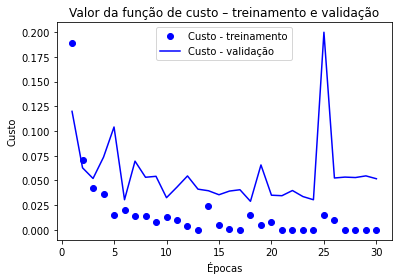

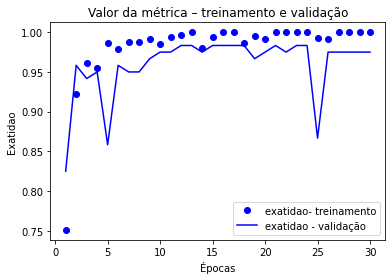

In [14]:
# Salva custos, métricas e epocas em vetores 
custo1 = history_dict1['loss']
acc1 = history_dict1['accuracy']
val_custo1 = history_dict1['val_loss']
val_acc1 = history_dict1['val_accuracy']

# Cria vetor de épocas
epocas1 = range(1, len(custo1) + 1)

# Gráfico dos valores de custo
plt.plot(epocas1, custo1, 'bo', label='Custo - treinamento')
plt.plot(epocas1, val_custo1, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas1, acc1, 'bo', label='exatidao- treinamento')
plt.plot(epocas1, val_acc1, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### Exercício #6: Cálculo dos custo e das métricas

Na célula abaixo crie um código para calcular os valores do custo e da exatidão para os dados de treinamento, validação e teste.

In [15]:
# PARA VOCÊ FAZER: Usando o método evaluate calcule o custo e exatidão resultantes do treinamento

### COMECE AQUI ### (≈ 3 linhas)
#Calculo do custo e exatidão para os dados de treinamento, validação e teste
custo_e_metricas_train1 = rna1.evaluate( train_carac, Y_train_hot, batch_size=1, verbose=1 )
custo_e_metricas_val1 = rna1.evaluate( val_carac, Y_val_hot, batch_size=1, verbose=1 )
custo_e_metricas_test1 = rna1.evaluate( test_carac, Y_test_hot, batch_size=1, verbose=1 )
### TERMINE AQUI ###

print(custo_e_metricas_train1)
print(custo_e_metricas_val1)
print(custo_e_metricas_test1)

120/120 [==============================] - 0s 974us/step - loss: 0.0368 - accuracy: 0.9667
[2.727534229052253e-05, 1.0]
[0.05176585912704468, 0.9750000238418579]
[0.0368398018181324, 0.9666666388511658]


**Saída esperada:**

    960/960 [==============================] - 0s 84us/sample - loss: 0.0066 - acc: 1.0000
    120/120 [==============================] - 0s 58us/sample - loss: 0.1147 - acc: 0.9750
    120/120 [==============================] - 0s 75us/sample - loss: 0.0552 - acc: 0.9667
    [0.006600972047696511, 1.0]
    [0.1146508887410164, 0.975]
    [0.055163777867952984, 0.96666664]

**Análise dos resultados:**

Pelos gráficos da função de custo e da métrica você deve observar o seguinte:

- O treinamento é bem rápido, sendo que em um pouco mais do que 15 épocas obtém-se uma exatidão de 100% para os dados de treinamento.
- Não ocorreu problema de overfitting no treinamento.
- A exatidão obtida para os dados de validação é de 97,5% e para os dados de teste é de 96,7%. Esses resultados são muito bons e foram obtidos com muito pouco trabalho e principalmente com um conjunto de dados relativamente pequeno.

### Verificação dos resultados

Execute a célula abaixo para calcular as previsões da sua RNA para as imagens dos dados de teste e depois verificar se algumas dessas previsões estão corretas. Troque a variável index (variando entre 0 e 119) para verificar se a sua RNA consegue classificar corretamente o sinal de mão mostrado nas imagens.

classe prevista = 5
classe real = 5


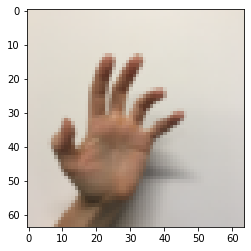

In [16]:
# Cálculo das classes previstas pela RNA com dropout

# Calculo das previsões da RNA
Y_test1 = rna1.predict(test_carac)

# Cálculo das classes previstas
classe1 = np.argmax(Y_test1, axis=1)

# Exemplo de uma imagem dos dados de teste
index = 20
plt.imshow(X_test_orig[index])
print ("classe prevista = " + str(np.squeeze(classe1[index])))
print ("classe real = " + str(np.squeeze(Y_test_orig[:, index])))

## 5 - RNA completa para processamento das imagens e classificação

O segundo método de realizar transferência de treinamento é mais demorado e computacionalmente mais exigente, mas os resultados em geral são melhores. Esse método consiste em estender a rna_base adicionando as camadas densas para classificação e treinar parcialmente a RNA resultante. A rna_base é adicionada como se fosse uma camada de uma RNA sequencial da mesma forma como adicionamos qualquer tipo de camada. Esse método permite criar uma nova RNA completa e, assim, obter resultados melhores do que somente usar a rna_base para extrair características.

### Exercício #7: Configuração da RNA completa usando a rna_base

Na célula abaixo crie um código para configurar uma nova RNA completa tendo como camadas convolucionais iniciais a rna_base e duas camadas densas na saída. As características dessa RNA são as seguintes:

- Tensor de entrada: tensor com as imagens; 
- Dimensão das imagens de entrada está na variável image_dim;
- Camadas convolucionais: rna_base;
- Camada intermediária: número de neurônios 64, função de ativação ReLu;
- Camada de saída Segunda camada convolucional: número neurônios 6, função de ativação softmax.

**Observação:** Nessa célula é criada uma nova camada de entrada para que a VGG16 aceite imagens com as dimensões do seu problema. Note que essa operação não é necessária em razão de já termos feito isso ao carregar e salvar a VGG16. Contudo, essa operação foi incluída para mostrar um exemplo de como alterar as dimensões da entrada de uma RNA convolucional.

In [17]:
# PARA VOCÊ FAZER: criação da RNA para classificação

# Importa do keras camada de entrada
from tensorflow.keras import layers

# Reinicializa o gerador de números aleatórios
np.random.seed(14)

# Cria uma nova camada de entrada com dimensão igual a das imagens (data_shape)
input_layer = layers.InputLayer(input_shape=image_dim, name="input_1")

# Troca a camada de entrada da rna_base de dimensão (None,None,None,3) para dimensão data_shape
rna_base.layers[0] = input_layer

# Inicia RNA sequencial com a rna_base e adiciona as camadas de flattenning e densas
#### COMECE AQUI ### (≈ 5 linhas) 
rna2 = models.Sequential()
rna2.add( rna_base )
rna2.add(layers.Flatten())
rna2.add(layers.Dense(64, activation='relu'))
rna2.add(layers.Dense(6, activation='softmax'))
### TERMINE AQUI ###

# Visualização da arquitetura da rede
rna2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 14,846,214
Trainable params: 14,846,214
Non-trainable params: 0
_________________________________________________________________


**Saída esperada:**

    Model: "sequential_1"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    vgg16 (Model)                (None, 2, 2, 512)         14714688  
    _________________________________________________________________
    flatten_1 (Flatten)          (None, 2048)              0         
    _________________________________________________________________
    dense_4 (Dense)              (None, 64)                131136    
    _________________________________________________________________
    dense_5 (Dense)              (None, 6)                 390       
    =================================================================
    Total params: 14,846,214
    Trainable params: 14,846,214
    Non-trainable params: 0
    _________________________________________________________________

Nota-se que a nova RNA possui 14.846.214 parâmetros, sendo que 14.714.688 parâmetros são da VGG16 e 131.526 são das camadas densas que você incluiu.

### Exercício #8: Congelamento dos parâmetros da rna_base

Antes de compilar e treinar essa nova RNA é muito importante “congelar” os parâmetros da rna_base. “Congelar” uma camada, ou um conjunto de camadas significa impedir que os seus parâmetros sejam atualizados durante o treinamento. Se isso não for realizado o aprendizado da RNA convolucional usada como base será modificado durante o treinamento. Na medida em que as camadas densas são inicializadas aleatoriamente, erros grandes na saída da RNA serão obtidos no início do treinamento gerando gradientes de grande amplitude, que são propagados na RNA destruindo o aprendizado prévio.

Na célula abaixo crie um código que congela os parâmetros da rna_base definindo o seu atributo trainable igual a False (ver notas de aula).

In [18]:
# PARA VOCÊ FAZER: congelamento dos parâmetros da rna_base

# Número de parâmetros a serem treinados antes do congelamento
print('Número de parâmetros treináveis antes do congelamento =', len(rna2.trainable_weights)) 

# Congelamento dos parâmetros da rna_base
#### COMECE AQUI ### (≈ 1 linha) 
rna_base.trainable = False
### TERMINE AQUI ###

# Número de parâmetros a serem treinados após o congelamento
print('Número de parâmetros treináveis após o congelamento =', len(rna2.trainable_weights)) 

Número de parâmetros treináveis antes do congelamento = 30
Número de parâmetros treináveis após o congelamento = 4


**Saída esperada:**

    Número de parâmetros treináveis antes do congelamento = 30
    Número de parâmetros treináveis após o congelamento = 4

### Exercício #9: compilação e treinamento da RNA

Agora você vai treinar a sua RNA usando o método de otimização Adams. Assim, na célula abaixo, compile e treine a sua RNA usando os seguinte hiperparâmetros:

- método Adam;
- taxa de aprendizagem = 0.001;
- beta1 = 0.9;
- beta2 = 0.999;
- decay = 0;
- número de épocas = 30;
- verbose = 1.

**Observação:** esse treinamento deve levar vários minutos.

In [19]:
# PARA VOCÊ FAZER: compilação e treinamento da RNA usando o método Adam

# Configuração do otimizador
### COMECE AQUI ### (≈ 2 linhas)
adam = optimizers.Adam( lr=0.001, beta_1=0.9, beta_2=0.999, decay=0 )
rna2.compile( optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'] )
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
history2 = rna2.fit( X_train, Y_train_hot, epochs=30, verbose=1, validation_data=( X_val , Y_val_hot ), batch_size=1 )
### TERMINE AQUI ###

Epoch 1/30
960/960 [==============================] - 62s 65ms/step - loss: 0.1757 - accuracy: 0.7667 - val_loss: 0.1031 - val_accuracy: 0.8833
Epoch 2/30
960/960 [==============================] - 61s 64ms/step - loss: 0.0673 - accuracy: 0.9271 - val_loss: 0.0650 - val_accuracy: 0.9583
Epoch 3/30
960/960 [==============================] - 61s 64ms/step - loss: 0.0455 - accuracy: 0.9615 - val_loss: 0.0941 - val_accuracy: 0.9167
Epoch 4/30
960/960 [==============================] - 61s 64ms/step - loss: 0.0349 - accuracy: 0.9708 - val_loss: 0.0516 - val_accuracy: 0.9500
Epoch 5/30
960/960 [==============================] - 66s 68ms/step - loss: 0.0334 - accuracy: 0.9667 - val_loss: 0.0616 - val_accuracy: 0.9250
Epoch 6/30
960/960 [==============================] - 62s 65ms/step - loss: 0.0140 - accuracy: 0.9896 - val_loss: 0.0422 - val_accuracy: 0.9417
Epoch 7/30
960/960 [==============================] - 61s 64ms/step - loss: 0.0281 - accuracy: 0.9708 - val_loss: 0.0473 - val_accuracy:

**Saída esperada:**

    Train on 960 samples, validate on 120 samples
    Epoch 1/30
    960/960 [==============================] - 33s 35ms/sample - loss: 1.1328 - acc: 0.5865 - val_loss: 0.6180 - val_acc: 0.8250
    .
    .
    .
    Epoch 30/30
    960/960 [==============================] - 32s 33ms/sample - loss: 0.0066 - acc: 1.0000 - val_loss: 0.1012 - val_acc: 0.9667

### Visualização dos resultados

Execute a célula a seguir para fazer os gráficos da função de custo e da métrica para os dados de treinamento e validação.

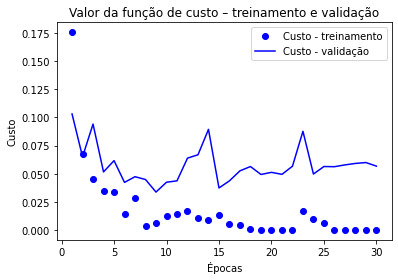

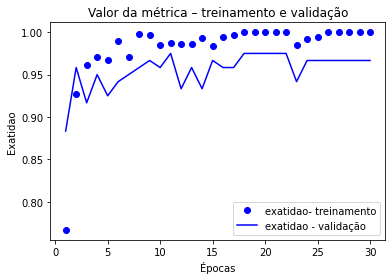

In [20]:
# Salva treinamento na variável history para visualização
history_dict2 = history2.history

# Salva custos, métricas e epocas em vetores 
custo2 = history_dict2['loss']
acc2 = history_dict2['accuracy']
val_custo2 = history_dict2['val_loss']
val_acc2 = history_dict2['val_accuracy']

# Cria vetor de épocas
epocas2 = range(1, len(custo2) + 1)

# Gráfico dos valores de custo
plt.plot(epocas2, custo2, 'bo', label='Custo - treinamento')
plt.plot(epocas2, val_custo2, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas2, acc2, 'bo', label='exatidao- treinamento')
plt.plot(epocas2, val_acc2, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### Exercício #10: Cálculo do custo e da métrica

Na célula abaixo crie um código para calcular os valores do custo e da exatidão para os dados de treinamento, validação e teste.


In [21]:
#PARA VOCÊ FAZER: Usando o método evaluate calcule o custo e exatidão resultantes do treinamento

#Calculo do custo e exatidão para os dados de treinamento, validação e teste
### COMECE AQUI ### (≈ 3 linhas)
custo_e_metricas_train2 = rna2.evaluate( X_train, Y_train_hot, batch_size=1, verbose=1 )
custo_e_metricas_val2 = rna2.evaluate( X_val, Y_val_hot, batch_size=1, verbose=1 )
custo_e_metricas_test2 = rna2.evaluate( X_test, Y_test_hot, batch_size=1, verbose=1 )
### TERMINE AQUI ###

print(custo_e_metricas_train2)
print(custo_e_metricas_val2)
print(custo_e_metricas_test2)

120/120 [==============================] - 7s 57ms/step - loss: 0.0373 - accuracy: 0.9667
[2.1258123524603434e-05, 1.0]
[0.05670107528567314, 0.9666666388511658]
[0.037308741360902786, 0.9666666388511658]


**Saída esperada:**

    960/960 [==============================] - 28s 29ms/sample - loss: 0.0053 - acc: 1.0000
    120/120 [==============================] - 3s 28ms/sample - loss: 0.1470 - acc: 0.9667
    120/120 [==============================] - 3s 29ms/sample - loss: 0.0903 - acc: 0.9750
    [0.0053149060598419355, 1.0]
    [0.14696299619972705, 0.96666664]
    [0.09027432998021444, 0.975]

**Análise dos resultados:**

Pelos gráficos e valores da função de custo e da métrica para os dados de treinamento, validação e teste você deve observar que o treinamento e os resultados obtidos com essa RNA é praticamente igual ao obtido pelo método de extração de características. Isso era de se esperar porque não alteramos a parte convolucional da rna_base, assim, as características extraídas das imagens são exatamente iguais nos dois casos e como a parte densa de classificação dos dois métodos tem as mesmas caraterísticas, o resultado não pode ser diferente nos dois casos.

Para que seja possível obter resultados melhores com essa nova RNA temos que fazer a sua sintonia fina, ou seja, temos que retreinar a parte final da rna_base para ela se ajustar melhor aos novos dados.

### Exercício #11: Descongelamento dos parâmetros do último bloco da rna_base

Agora você vai realizar a sintonia fina das últimas 3 camadas convolucionais da rna_base. No caso da VGG16 usada como base isso significa que todas as camadas até o 4º bloco permanecem congeladas e as camadas do 5º bloco são descongeladas para serem retreinadas.

Na célula abaixo crie um código que descongela as camadas convolucionais do último bloco da rna_base. Note que para isso você precisa saber os “nomes” das várias camadas da RNA. Verifique o nome da primmeira camada do último bloco da rna_base para incluir como um sinal para iniciar o descongelamento das camadas (ver notas de aula). 

In [27]:
# PARA VOCÊ FAZER: descongelamento das camadas convolucionais do block5.

# Descongela todas as camadas da rna_base
### COMECE AQUI ### (≈ 2 linhas)
rna_base.trainable = True
### TERMINE AQUI ###

# Percorre camadas da rna_base procurando pelo 5º bloco
### COMECE AQUI AQUI ### (≈ 7 linhas)
for layer in rna_base.layers:
    if layer.name[:6] == 'block5':
        layer.trainable = True
    else:
        layer.trainable = False      
### TERMINE AQUI ###        

# Número de parâmetros a serem treinados após o descongelamento parcial
print('Número de parâmetros treináveis após o descongelamento =', len(rna2.trainable_weights)) 

Número de parâmetros treináveis após o descongelamento = 10


**Saída esperada:**

    Número de parâmetros treináveis após o descongelamento = 10

**Observação:** No treinamento da sua RNA 10 tensores de parâmetros serão treinados. Sendo que 6 pretencem às 3 últimas camadas convolucionais da rna_base (3 tensores de pesos dos filtros e 3 tensores de viéses) e 4 pertencem às duas camadas densas do final da RNA.


### Exercício #12: Continuação do treinamento (sintonia fina) da RNA

Agora a RNA está pronta para ser retreinada e sintonizada para o novo problema. Lembre-se de que a sintonia fina deve ser realizada com uma taxa de aprendizado muito pequena, porque se deseja limitar o valor das modificações das camadas convolucionais que estão sendo ajustadas. Atualizações muito grande dos parâmetros podem destruir completamente o treinamento original.

Agora você vai compilar novamente e retreinar a sua RNA. Assim, na célula abaixo, compile e treine a sua RNA usando os seguinte hiperparâmetros:

- método Adam;
- taxa de aprendizagem = 2e-05;
- beta1 = 0.9;
- beta2 = 0.999;
- decay = 0;
- número de épocas = 30;
- verbose = 1.

**Observação:** Esse treinamento deve levar vários minutos.

In [28]:
# PARA VOCÊ FAZER: compilação e treinamento da RNA usando o método Adam

# Salva o aprendizado anterior para se precisar começar de novo
rna3 = rna2

# Configuração do otimizador
### COMECE AQUI ### (≈ 2 linhas)
adam = optimizers.Adam( lr=2e-5, beta_1=0.9, beta_2=0.999, decay=0 )
rna3.compile( optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'] )
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
history3 = rna3.fit( X_train, Y_train_hot, epochs=30, verbose=1, validation_data=( X_val , Y_val_hot ), batch_size=1 )
### TERMINE AQUI ###

Epoch 1/30
960/960 [==============================] - 102s 107ms/step - loss: 0.0985 - accuracy: 0.9323 - val_loss: 0.0743 - val_accuracy: 0.9333
Epoch 2/30
960/960 [==============================] - 102s 107ms/step - loss: 0.0573 - accuracy: 0.9594 - val_loss: 0.0747 - val_accuracy: 0.9333
Epoch 3/30
960/960 [==============================] - 104s 108ms/step - loss: 0.0359 - accuracy: 0.9729 - val_loss: 0.0913 - val_accuracy: 0.9083
Epoch 4/30
960/960 [==============================] - 103s 107ms/step - loss: 0.0292 - accuracy: 0.9760 - val_loss: 0.0275 - val_accuracy: 0.9750
Epoch 5/30
960/960 [==============================] - 103s 108ms/step - loss: 0.0213 - accuracy: 0.9823 - val_loss: 0.2595 - val_accuracy: 0.8583
Epoch 6/30
960/960 [==============================] - 103s 107ms/step - loss: 0.0247 - accuracy: 0.9812 - val_loss: 0.0144 - val_accuracy: 0.9917
Epoch 7/30
960/960 [==============================] - 103s 107ms/step - loss: 0.0165 - accuracy: 0.9885 - val_loss: 0.0432 -

**Saída esperada:**

    Train on 960 samples, validate on 120 samples
    Epoch 1/30
    960/960 [==============================] - 39s 41ms/sample - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0995 - val_acc: 0.9583
    .
    .
    .
    Epoch 30/30
    960/960 [==============================] - 37s 39ms/sample - loss: 1.3403e-05 - acc: 1.0000 - val_loss: 0.1098 - val_acc: 0.9833

### Visualização dos resultados

Execute a célula a seguir para fazer os gráficos da função de custo e da métrica para os dados de treinamento e validação.

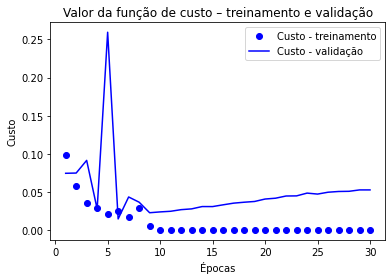

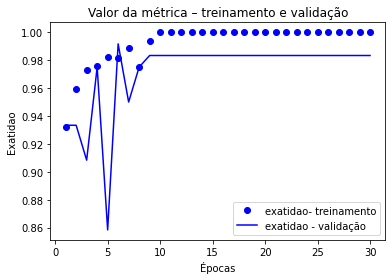

In [29]:
# Salva treinamento na variável history para visualização
history_dict3 = history3.history

# Salva custos, métricas e epocas em vetores 
custo3 = history_dict3['loss']
acc3 = history_dict3['accuracy']
val_custo3 = history_dict3['val_loss']
val_acc3 = history_dict3['val_accuracy']

# Cria vetor de épocas
epocas3 = range(1, len(custo3) + 1)

# Gráfico dos valores de custo
plt.plot(epocas3, custo3, 'bo', label='Custo - treinamento')
plt.plot(epocas3, val_custo3, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas3, acc3, 'bo', label='exatidao- treinamento')
plt.plot(epocas3, val_acc3, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

Execute a célula abaixo para calcular os valores do custo e da exatidão para os dados de treinamento, validação e teste.

In [30]:
#Calculo do custo e exatidão para os dados de treinamento, validação e teste
custo_e_metricas_train3 = rna3.evaluate(X_train, Y_train_hot)
custo_e_metricas_val3 = rna3.evaluate(X_val, Y_val_hot)
custo_e_metricas_test3 = rna3.evaluate(X_test, Y_test_hot)

print(custo_e_metricas_train3)
print(custo_e_metricas_val3)
print(custo_e_metricas_test3)

4/4 [==============================] - 4s 893ms/step - loss: 0.0488 - accuracy: 0.9750
[1.2417636363615259e-10, 1.0]
[0.05251685902476311, 0.9833333492279053]
[0.04879579320549965, 0.9750000238418579]


**Saída esperada:**

    960/960 [==============================] - 27s 29ms/sample - loss: 1.2559e-05 - acc: 1.0000
    120/120 [==============================] - 3s 28ms/sample - loss: 0.1098 - acc: 0.9833
    120/120 [==============================] - 3s 28ms/sample - loss: 0.0696 - acc: 0.9667
    [1.2558833835403979e-05, 1.0]
    [0.10976095756777796, 0.98333335]
    [0.06959424574548999, 0.96666664]


### Análise dos resultados ###

- Pode-se observar que o treinamento não inicia do zero pois as camadas densas da RNA já foram pré-treinadas e agora somente estão sendo ajustados os parâmetros das últimas camadas convolucionais da rna_base e retreinando as camadas densas.
- Uma exatidão de 97,5% para os dados de validação e de 96,7% para os dados de teste represetam um resultado muito bom, considerando o pequeno conjunto de dados utilizado.
- Observa-se que os resultados da exatidão para os dados de teste não melhoraram muito. Isso ocorre provavelmente porque o número de exemplos de teste é pequeno e também provavelmente porque os exemplos classificados de forma errada devem ser muito difícieis para qualquer sistema identificar corretamente.

### Exercício #13: Verificação dos resultados

Na célula abaixo calcule a previsões da sua RNA para as imagens dos dados de teste e depois verifique se algumas dessas previsões estão corretas. Note que a previsão da RNA é um vetor de 6 elementos com as probabilidades da imagem mostrar os seis sinais. Para detereminar a classe prevista deve-se transformar esse vetor em um número inteiro de 0 a 5, que representa o sinal sendo mostrado. Para fazer essa transformação use a função numpy argmax(Y_test, axis=?), onde Y_test_prev é o tensor com as saídas previstas pela RNA. Em qual eixo você deve calcular o índice da maior probabilidade?

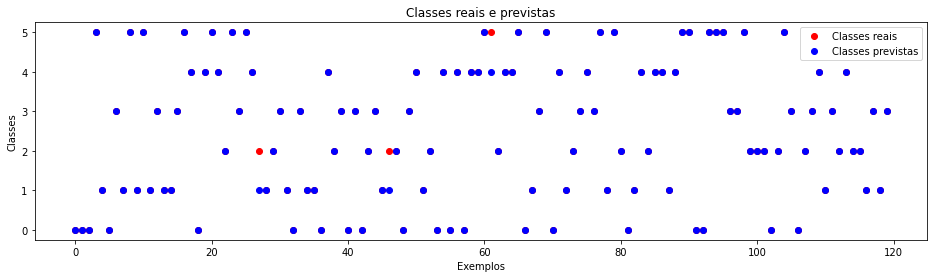

In [31]:
# PARA VOCÊ FAZER: cálculo das classes previstas pela RNA com dropout

# Calculo das previsões da RNA
### COMECE AQUI ### (≈ 1 linha)
Y_test_prev = rna3.predict( X_test )
### TERMINE AQUI ###

# Cálculo das classes previstas
### COMECE AQUI ### (≈ 1 linha)
classe3 = np.argmax( Y_test_prev, axis=1 )
### TERMINE AQUI ###

# Gráfico das classes reais e previstas
# Fazer o gráfico das classes reais e previstas
plt.figure(figsize=(16, 4))
plt.plot(Y_test, 'ro', label='Classes reais')
plt.plot(classe3, 'bo', label='Classes previstas')
plt.title('Classes reais e previstas')
plt.xlabel('Exemplos')
plt.ylabel('Classes')
plt.legend()
plt.show()

**Saída esperada:**

<img src="classes_reais_previstas.png" style="width:950px;height:280px;">

**Comentários:**

- Uma previsão errada de classe pode ser dectada pelos círculos vermelhos, pois quando a classe prevista é igual à classe real o círculo azul é colocado em cima do vermelho tapando-o.

- No gráfico devem aparecer mais círculos azuis do que vermelhos indicando que existem mais acertos do que erros na previsão das classes.



**Visualização de previsões erradas:**

Use o gráfico acima e escolha um exemplo onde a previsão da sua RNA está errada. Na célula abaixo troque a variável index e execute-a para verificar se o exemplo tem alguma particularidade que dificulta a sua RNA de prever corretamente a classe desse exemplo.

classe prevista = 4
classe real = 5


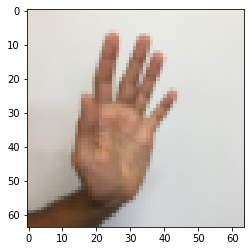

In [32]:
# Cálculo das classes previstas pela RNA com dropout

# Exemplo de uma imagem dos dados de teste
index = 25
plt.imshow(X_test_orig[index])
print ("classe prevista = " + str(np.squeeze(classe3[index])))
print ("classe real = " + str(np.squeeze(Y_test_orig[:, index])))

### Conclusões

Uma exatidão de quase 97% para as imagens de teste representa um resultado excelente. Esse resultado é supreendente tendo em vista o pequeno número de imagens utilizadas. 

A partir desses resultados você pode concluir o seguinte:

- Transferência de aprendizado consiste de uma abordagem fácil e altamente eficiente para desenvolver uma nova aplicação.
- Transferência de aprendizado é muito eficiente, principalmente quando o banco de dados disponível é pequeno.
- Existem dois métodos para usar uma RNA pré-treinada. Qualquer um dos dois métodos é muito eficiente para obter sistemas com alto desempenho, mesmo quando o conjunto de dados é pequeno.
- A transferência de treinamento realizada com treinamento parcial com  a técnica de sintonia fina é extremamente eficiente para obter sistemas com alto desempenho, mesmo quando o conjunto de dados é pequeno.